In [1]:
import numpy as np
import scipy.optimize as op
import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Simple Linear Regression
To predict how the change in water level (x) determines the outflow of water from the dam (y).

In [2]:
mat = scipy.io.loadmat('ex5data1.mat')

In [3]:
X = mat['X'].ravel()
X_val = mat['Xval'].ravel()
X_test = mat['Xtest'].ravel()
y = mat['y'].ravel()
y_val = mat['yval'].ravel()
y_test = mat['ytest'].ravel()

m = len(X)

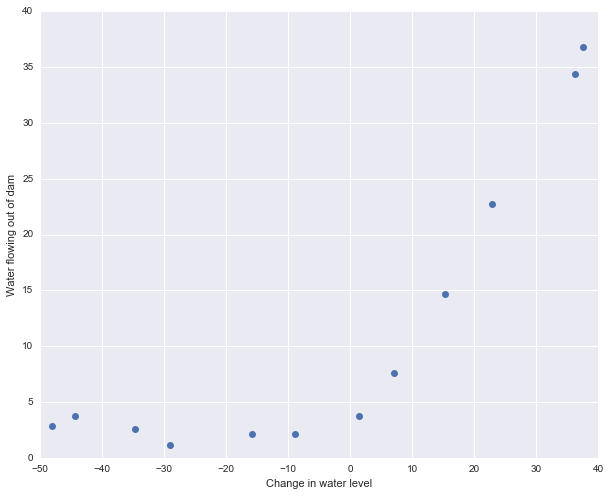

In [4]:
# Plot data

fig = plt.figure(figsize=(10,8))
plt.plot(X, y, 'o')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of dam')

In [5]:
def add_bias_feature(X):
    
    # Adds a feature of 1's to the data.
    
    m=len(X)
    
    if len(np.shape(X)) == 1:
        X = X.reshape(m, 1)
    else:
        m,n = np.shape(X)
        X = X.reshape(m,n)
        
    X_0 = np.ones((m,1))
    
    return np.append(X_0, X, 1)

In [6]:
def cost_function(theta, X, y, lambda_):
    
    # Linear regression cost function with regularization.
    
    cost = sum(((X.dot(theta) - y) **2))/(2*m) + sum(theta[1:] **2) * (lambda_/(2*m))
    
    return cost

In [7]:
def gradient(theta, X, y, lambda_):
    
    # Deravitive of cost function.
    
    grad = np.zeros(len(theta))
    
    # No need to regularize the intercept.
    
    grad[0] = (X.dot(theta) - y).dot(X[:,0]) / m
    grad[1:] = (X.dot(theta) - y).dot(X[:,1:]) / m + (lambda_/m) * theta[1:]

    return grad

In [8]:
def train_linear_reg(X, y, lambda_):
    
    # Minimizes cost function with respect to theta.
    
    initial_theta = np.ones(np.shape(X)[1])
    
    result = op.minimize(fun=cost_function, 
                     x0=initial_theta, 
                     args=(X, y, lambda_), 
                     method= 'TNC', 
                     jac=gradient)
    
    return result.x

In [9]:
optimal_theta = train_linear_reg(add_bias_feature(X), y, 0)

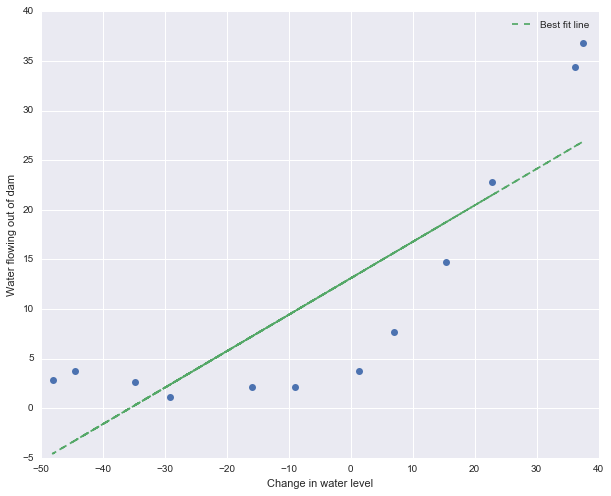

In [10]:
# Simple linear regression over a non-linear dataset.

plt.figure(figsize=(10,8))
plt.plot(X, y, 'o')
plt.plot(X, (add_bias_feature(X).dot(optimal_theta)), '--', label = 'Best fit line')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of dam')
plt.legend()

In [11]:
def learning_curve(X, y, X_val, y_val, lambda_):
    
    # Shows graphically how varying the number of training examples used to fit 
    # the linear model affects the training and validation errors.
    
    train_error = []
    val_error = []
    
    for i in range(m):
        X_sub = X[:i+1,:]
        y_sub = y[:i+1]
        theta_sub = train_linear_reg(X_sub, y_sub, lambda_)
        
        # Cost of training data subset.
        cost_train = cost_function(theta_sub, X_sub, y_sub, lambda_)
        
        # Cost over entire validation set.
        cost_cv = cost_function(theta_sub, X_val, y_val, lambda_)
        
        train_error.append(cost_train)
        val_error.append(cost_cv)
        
    plt.figure(figsize = (12,6))
    plt.plot(range(1,13), train_error)
    plt.plot(range(1,13), val_error)
    plt.ylim(0,120)
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Error')
    plt.legend(['Training Error', 'Cross Validation Error'])

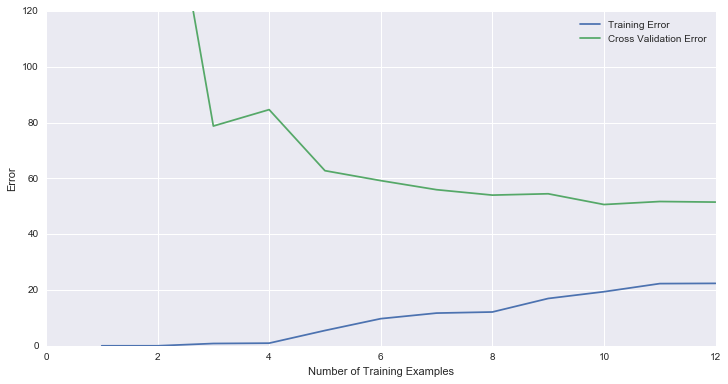

In [12]:
learning_curve(add_bias_feature(X), y, add_bias_feature(X_val), y_val, 0)

Because the model has high bias we find that although the CV error decreases over time
the model lacks the complexity to perform well on non-linear data and simply adding more data
is not a viable solution to underfitting.

# Adding polynomial features to better fit data

In [13]:
def poly_features(X, p):

    # Adds polynomial features to original data such that each new column corresponds
    # to the original values of x raised to the power of that row's index + 1
    # i.e x ^ (1,2,3,...,p).
    
    X_poly = []
    
    for i in range(1, (p+1)):
        X_poly.append(X**i)
        
    return np.array(X_poly).T

In [14]:
def feature_normalize(X):
    
    # Normalize features so mean is 0 and standard deviation is 1
    
    mu = np.mean(X,0)
    sigma = np.std(X,0)
    X_norm = (X-mu)/sigma
    
    return X_norm, mu, sigma

In [15]:
def plot_poly(X, y):
    
    # Visualize how the complexity of the fit varies as we increase the polynomial degree.
    fig, axs = plt.subplots(2,4, figsize=(15, 8))
    
    # Plot over range exceeding scope of original data
    min_x = min(X)
    max_x = max(X)
    x = np.arange(min_x - 30, max_x + 40, 0.5)
    
    i = 0
    
    # Iterate through axes
    axs = axs.ravel()
    for p in range(1, 9): 
        
        # Finds best fit theta parameters for degree p using original data X.
        X_poly_fit = poly_features(X, p)
        X_poly_fit, mu, sigma = feature_normalize(X_poly_fit)
        X_poly_fit = add_bias_feature(X_poly_fit)
        poly_theta = train_linear_reg(X_poly_fit, y, 0)
        
        # Transform data used for plotting using new data range x.
        X_poly_plot = poly_features(x, p)
        X_poly_plot = (X_poly_plot-mu)/sigma
        X_poly_plot = add_bias_feature(X_poly_plot)
        
        axs[i].plot(X, y, 'o')
        axs[i].plot(x, X_poly_plot.dot(poly_theta), '--')
        axs[i].set_title('Polynomial degree: ' + str(p))
        axs[i].set_ylim([min(y)-15, max(y)+15])
        axs[i].set_xlim([min(x), max(x)])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
        i += 1

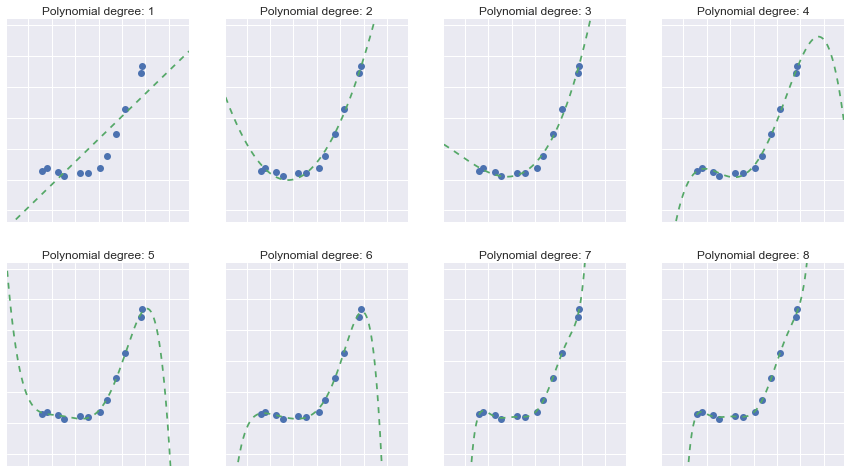

In [16]:
plot_poly(X, y)

In [17]:
def validation_curve(X, y, X_val, y_val):
    
    # Adjust lambda to train multiple models in order visualize the affect of lambda
    # on the training and cross validation errors
    
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    train_error = []
    val_error = []
    
    for i in range(len(lambda_vec)):
        
        theta = train_linear_reg(X, y, lambda_vec[i])
        training_cost = cost_function(theta, X, y, 0)
        cv_cost = cost_function(theta, X_val, y_val, 0)
        
        train_error.append(training_cost)
        val_error.append(cv_cost)
        
    plt.figure(figsize = (12,6))
    plt.plot(lambda_vec, train_error)
    plt.plot(lambda_vec, val_error)
    plt.xlabel('Lambda')
    plt.ylabel('Error')
    plt.legend(['Training', 'Cross Validation'])

The optimal value of lambda allows us to minimize our CV cost (approx 3).

In [18]:
# Degree of polynomial.

p = 8

In [19]:
# Add poly features to data used to train model.

X_poly = poly_features(X, p)
X_poly, mu, sigma = feature_normalize(X_poly)
X_poly = add_bias_feature(X_poly)

In [20]:
# Add poly features to data used for cross validation
# (normalize w.r.t. training data).

X_poly_val = poly_features(X_val, p);
X_poly_val = (X_poly_val - mu) / sigma
X_poly_val = add_bias_feature(X_poly_val)

In [21]:
# Add poly features to data used to test model
# (normalize w.r.t. the training data).

X_poly_test = poly_features(X_test, p);
X_poly_test = (X_poly_test - mu) / sigma
X_poly_test = add_bias_feature(X_poly_test)

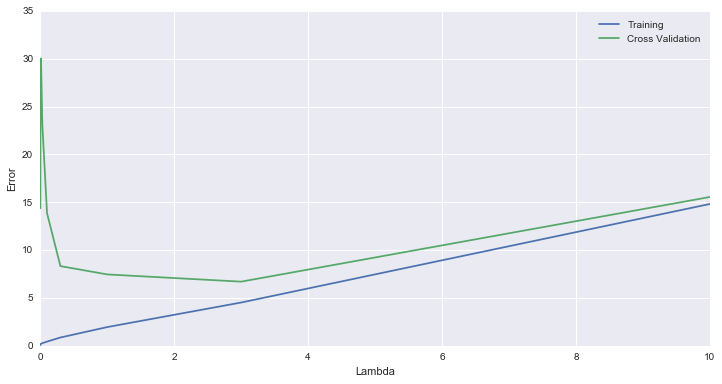

In [22]:
validation_curve(X_poly, y, X_poly_val, y_val)

The optimal value of lambda allows us to minimize our CV cost (approx 3).

In [23]:
# Train the model to learn optimal parameters.

poly_theta = train_linear_reg(X_poly, y, 3)

In [24]:
# Evaluate the model

training_cost = cost_function(poly_theta, X_poly, y, 0)
cv_cost = cost_function(poly_theta, X_poly_val, y_val, 0)
test_cost = cost_function(poly_theta, X_poly_test, y_test, 0)

print('Training set error: {0:.3g}'.format(training_cost))
print('CV set error: {0:.3g}'.format(cv_cost))
print('Test set error: {0:.3g}'.format(test_cost))

Training set error: 4.53
CV set error: 6.71
Test set error: 6.25
